# OCR_python 성능 비교하기

## 1. test 데이터 보여주기

In [1]:
import os
import matplotlib.pyplot as plt
import glob
import cv2
from PIL import Image, ImageDraw

In [2]:
work_dir = os.getenv('HOME') + '/aiffel/ocr_python/data'
img_file_path = glob.glob(work_dir + '/*.jpg')
img = [cv2.imread(file_path) for file_path in img_file_path] 
print(img_file_path)

['/home/aiffel0038/aiffel/ocr_python/data/image2.jpg', '/home/aiffel0038/aiffel/ocr_python/data/image1.jpg', '/home/aiffel0038/aiffel/ocr_python/data/20160705_141402.jpg', '/home/aiffel0038/aiffel/ocr_python/data/20160727_091310.jpg', '/home/aiffel0038/aiffel/ocr_python/data/image3.jpg', '/home/aiffel0038/aiffel/ocr_python/data/20160709_092514.jpg', '/home/aiffel0038/aiffel/ocr_python/data/20160711_123000.jpg', '/home/aiffel0038/aiffel/ocr_python/data/test_image.jpg', '/home/aiffel0038/aiffel/ocr_python/data/20160723_150222.jpg', '/home/aiffel0038/aiffel/ocr_python/data/20160706_171505.jpg', '/home/aiffel0038/aiffel/ocr_python/data/20160706_164055.jpg', '/home/aiffel0038/aiffel/ocr_python/data/20160706_163934.jpg']


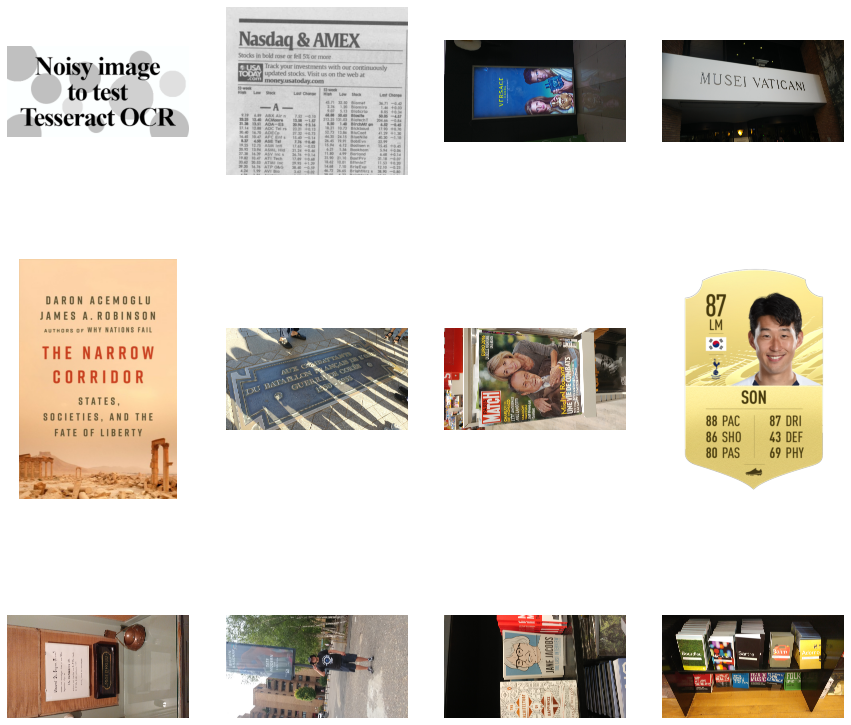

In [3]:
import matplotlib.image as img
plt.figure(figsize=(15, 15))

for idx, image in enumerate(img_file_path):
    plt.subplot(3, 4, idx+1)
    im=img.imread(image)
    plt.imshow(im)
    plt.axis('off')

## 2. google api로 보여주기

In [4]:
!echo "export GOOGLE_APPLICATION_CREDENTIALS=$HOME/aiffel/ocr_python/my_google_api_key.json" >> ~/.bashrc

In [6]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [7]:
# 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
!ls -l $GOOGLE_APPLICATION_CREDENTIALS
# 입력 이미지 경로를 지정해 주세요.

for a in img_file_path:
    detect_text(a)

-rw-rw-r-- 1 aiffel0038 aiffel0038 2349 10월  7 14:35 /home/aiffel0038/aiffel/ocr_python/my_google_api_key.json
Texts:

"Noisy image
to test
Tesseract OCR
"

"Noisy"

"image"

"to"

"test"

"Tesseract"

"OCR"
bounds: (198,108),(294,108),(294,139),(198,139)
Texts:

"Nasdaq & AMEX
Stocks in bold rose or fell 5% or more
Track your investments with our continuously
USA
TODAY updated stocks. Visit us on the web at
.com
money.usatoday.com
52-week
High
$2-week
High
Low Stock
Last Change
Low Stack
Last Change
45.71 32.50 Biomet
1.20 Biomiro
5.13 Bloscrip
68.88 50.65 Blosite
212.25 131.03 BiotechT
1.40 BirchMt gn
18.21 10.73 Bickbaud
52.73 13.86 BluCoat
44.35 24.15 BlueNile
26.45 19.91 BobEvn
6.12 Bodisen n
1.56 Bookham
4.99 Borland
31.90 21.10 BostPrv
BttminT
7.10 BrigExp
46.72 26.65 BrightHrz s 38.90 -0.80
36.71 -0.42
1.46 +0.03
8.05 +0.34
50.05 -4.57
204.66 -0.84
6.52 -0.45
17.90 +0.70
41.29 +1.30
40.30 -1.10
22.99
15.45 +0.45
5.94 +0.06
6.68 +0.14
31.18 -0.07
11.53 +0.20
12.10-0.23
-A-
2.76


## 3. keras-ocr 사용하기

In [8]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /home/aiffel0038/.keras-ocr/craft_mlt_25k.h5
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Looking for /home/aiffel0038/.keras-ocr/crnn_kurapan.h5


In [9]:
images = [ keras_ocr.tools.read(path) for path in img_file_path]
prediction_groups = [pipeline.recognize([path]) for path in img_file_path]

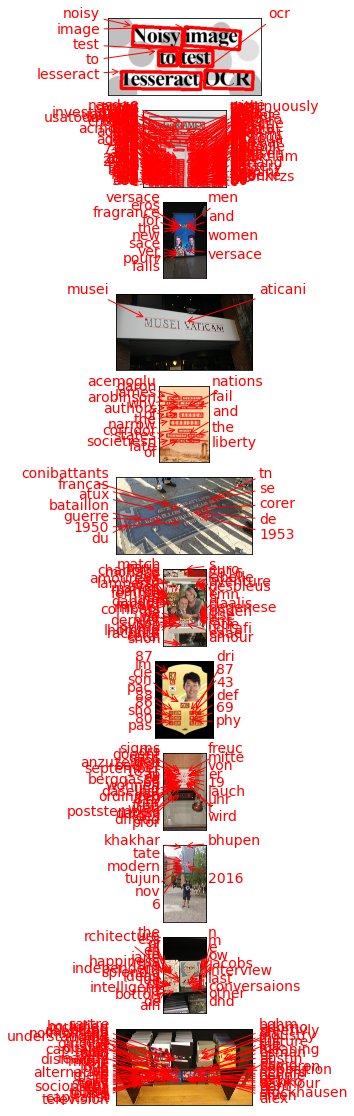

In [10]:
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

## 4. tesseract 사용하기

In [23]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path, output_path):
    s = os.path.splitext(image_path)
    s = os.path.split(s[0])
    name = s[1]
    output_path = output_path + name +'/'
    
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)
    img = cv2.imread(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list, img, name

In [29]:
output_path = work_dir + '/tesseract/'
Tesser_dict = {}
img_dict = {}
for idx, path in enumerate(img_file_path):    
    name, cropped_image_path_list, imgs = crop_word_regions(path, output_path)

/home/aiffel0038/aiffel/ocr_python/data/tesseract/image2/0000.png
/home/aiffel0038/aiffel/ocr_python/data/tesseract/image2/0001.png
/home/aiffel0038/aiffel/ocr_python/data/tesseract/image2/0002.png
/home/aiffel0038/aiffel/ocr_python/data/tesseract/image2/0003.png
/home/aiffel0038/aiffel/ocr_python/data/tesseract/image2/0004.png
/home/aiffel0038/aiffel/ocr_python/data/tesseract/image1/0000.png
/home/aiffel0038/aiffel/ocr_python/data/tesseract/image1/0001.png
/home/aiffel0038/aiffel/ocr_python/data/tesseract/image1/0002.png
/home/aiffel0038/aiffel/ocr_python/data/tesseract/image1/0003.png
/home/aiffel0038/aiffel/ocr_python/data/tesseract/image1/0004.png
/home/aiffel0038/aiffel/ocr_python/data/tesseract/image1/0005.png
/home/aiffel0038/aiffel/ocr_python/data/tesseract/image1/0006.png
/home/aiffel0038/aiffel/ocr_python/data/tesseract/image1/0007.png
/home/aiffel0038/aiffel/ocr_python/data/tesseract/image1/0008.png
/home/aiffel0038/aiffel/ocr_python/data/tesseract/image1/0009.png
/home/aiff

<Figure size 1080x1080 with 0 Axes>

## 5. 성능비교

### 1. google-ocr

In [78]:
test_dir = work_dir + '/image3.jpg'
print(test_dir)

/home/aiffel0038/aiffel/ocr_python/data/image3.jpg


In [76]:
!ls -l $GOOGLE_APPLICATION_CREDENTIALS
# 입력 이미지 경로를 지정해 주세요.

detect_text(test_dir)

-rw-rw-r-- 1 aiffel0038 aiffel0038 2349 10월  7 14:35 /home/aiffel0038/aiffel/ocr_python/my_google_api_key.json
Texts:

"DARON ACEMOGLU
JAMES A. ROBINSON
AUTHORS OF WHY NATIONS FAIL
THE NARRO W
CORRIDOR
STATES,
SOCIETIES, AND THE
FATE OF LIBERTY
"

"DARON"

"ACEMOGLU"

"JAMES"

"A."

"ROBINSON"

"AUTHORS"

"OF"

"WHY"

"NATIONS"

"FAIL"

"THE"

"NARRO"

"W"

"CORRIDOR"

"STATES,"

"SOCIETIES,"

"AND"

"THE"

"FATE"

"OF"

"LIBERTY"
bounds: (205,425),(306,425),(306,442),(205,442)


### 2. keras-ocr

In [80]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /home/aiffel0038/.keras-ocr/craft_mlt_25k.h5
Looking for /home/aiffel0038/.keras-ocr/crnn_kurapan.h5


In [94]:
images = [keras_ocr.tools.read(test_dir)]
prediction_groups = [pipeline.recognize([test_dir])]
print(images)

[array([[[222, 188, 143],
        [234, 200, 155],
        [234, 200, 155],
        ...,
        [238, 197, 153],
        [239, 198, 154],
        [238, 199, 156]],

       [[236, 202, 157],
        [248, 214, 169],
        [248, 214, 169],
        ...,
        [252, 211, 167],
        [253, 212, 168],
        [252, 213, 170]],

       [[234, 200, 155],
        [246, 212, 167],
        [249, 212, 168],
        ...,
        [252, 211, 167],
        [253, 212, 168],
        [252, 214, 169]],

       ...,

       [[213, 165, 116],
        [230, 180, 131],
        [231, 179, 129],
        ...,
        [188, 123,  65],
        [189, 124,  66],
        [191, 125,  65]],

       [[220, 170, 121],
        [227, 177, 128],
        [219, 167, 117],
        ...,
        [221, 159, 100],
        [210, 145,  87],
        [198, 134,  73]],

       [[218, 168, 119],
        [226, 176, 127],
        [224, 172, 122],
        ...,
        [254, 192, 133],
        [232, 170, 111],
        [214, 150,  89]

IndexError: list index out of range

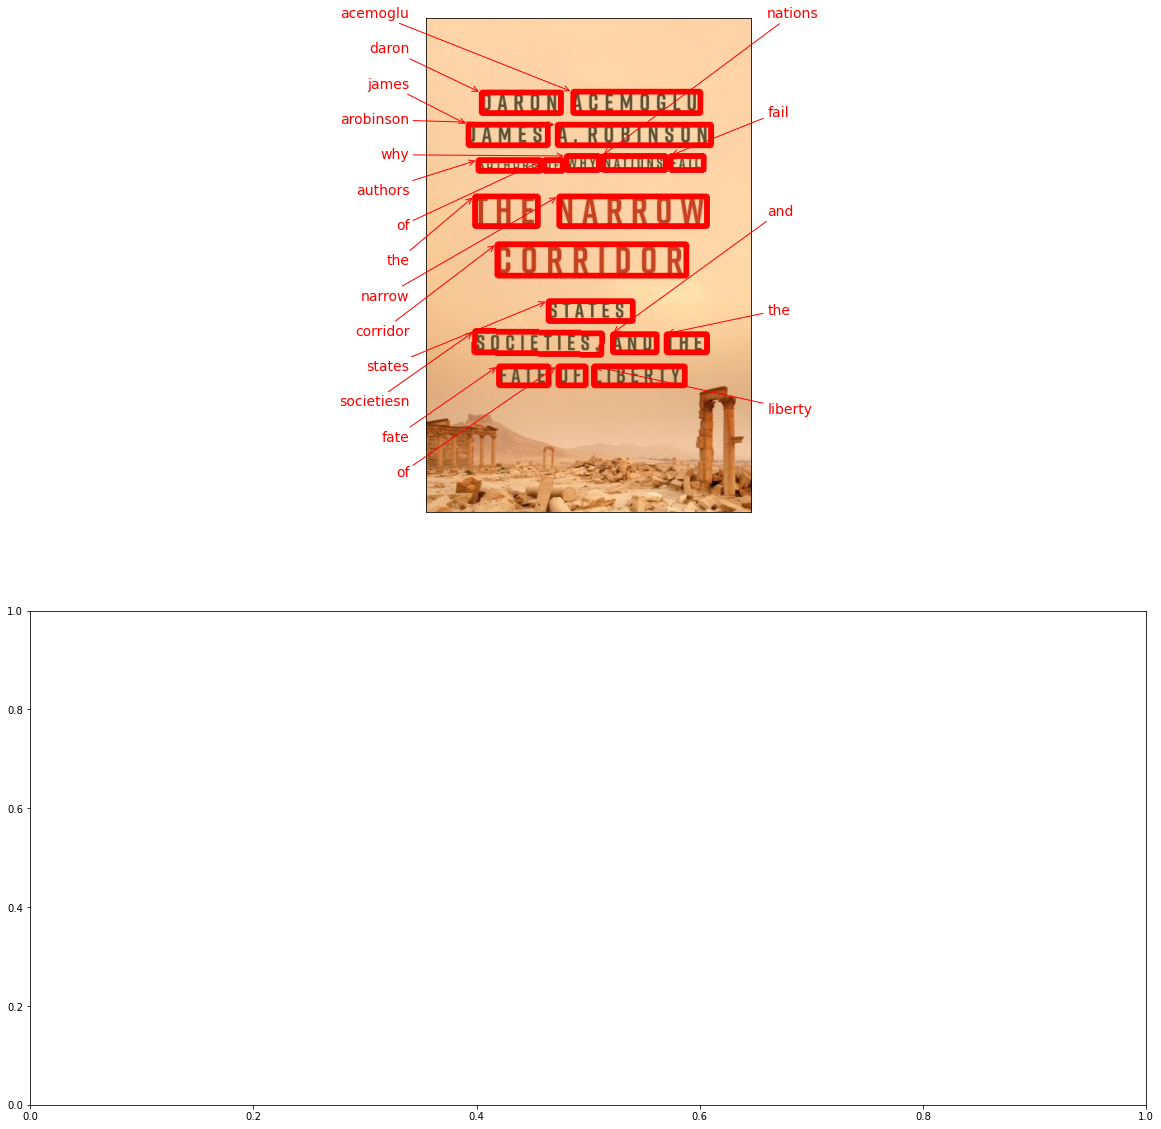

In [102]:
fig, axs = plt.subplots(2,1, figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

### 3. tesseract

In [47]:
sample_path = work_dir + '/tesseract/image3'
sample_img_file_path = glob.glob(sample_path + '/*.png')
sample_img = [cv2.imread(file_path) for file_path in sample_img_file_path]

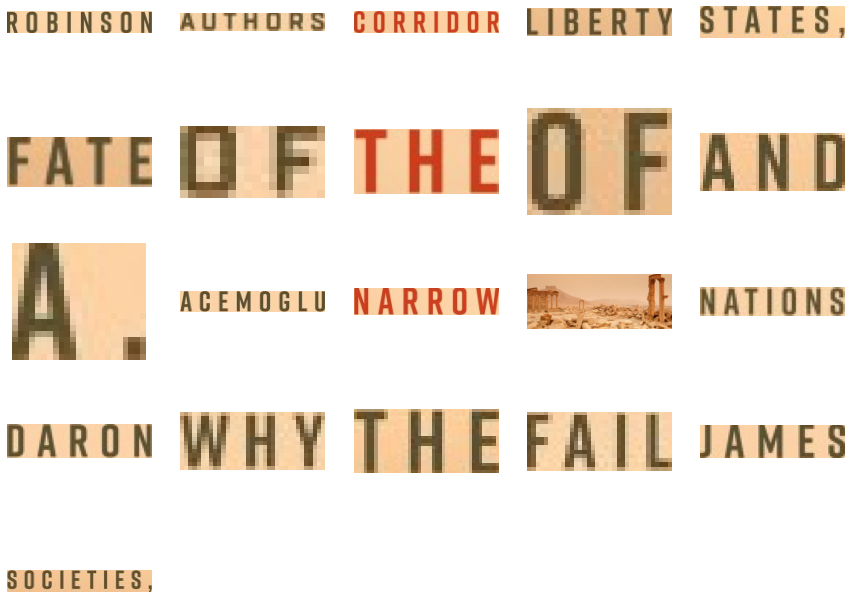

In [49]:
import matplotlib.image as img
plt.figure(figsize=(15, 15))

for idx, image in enumerate(sample_img_file_path):
    plt.subplot(6, 5, idx+1)
    im=img.imread(image)
    plt.imshow(im)
    plt.axis('off')

원본과 비교한 결과 가장 google-ocr같은 경우 narrow를 narro와 w를 따로 구분했지만 정확한 편이었다.    
keras-ocr은 저자 이름인 James A. Robinson에서 arobinson으로 읽어냈다.    
tesseract는 잘 구분해 냈지만 그림을 글자로 인식해서 출력했다.     

다른 문헌을 읽은 결과 google-ocr은 대소문자 구분이 명확한 반면 keras-ocr과 tesseract는 그러한 점에서 약점을 보인다고 한다.